# Example for applying the adaptive variational algorithm on simulated data

In [1]:
import copy
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.NL_hawkes import NonlinHawkesBasis, LinkFunction
from src.utils import nb_excursions, gq_points_weights, nd_block_diag, intensity_process

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import gamma, norm, beta
from time import time
from scipy.special import expit
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
from scipy import optimize
import json
import pickle
import arviz as az
from types import SimpleNamespace

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Create simulated data set

In [2]:
# General parameters
number_of_dimensions=2
number_of_basis=2
A=0.05
basis='histogram'
T=200
nl_models = {
    "sigmoid": {"theta": 0.0, "beta": 0.2, "eta": 10.0, "lamda":20.0 },
}
link = 'sigmoid'

In [3]:
# Model parameters
base_activation = np.array([5., 4.0] * (number_of_dimensions // 2) ) # background rates
graph_2D = np.array([[1, 1],[0, 1]], dtype=np.int64)
graph = scipy.linalg.block_diag(*([graph_2D] * (number_of_dimensions //2))) # graph of interaction
full_graph = np.ones((number_of_dimensions,number_of_dimensions), dtype=int)
w01 = np.linspace(3,2,num=number_of_basis).reshape(1,-1)
w02 = np.linspace(2,1,num=number_of_basis).reshape(1,-1)
w03 = np.linspace(-3,-2,num=number_of_basis).reshape(1,-1)
block_exc = np.concatenate([w01, w02, w02, w01], axis=0).reshape(2, 2, -1)
block_inh = np.concatenate([w03, w02, w02, w03], axis=0).reshape(2, 2, -1)
weight = {
    'exc': nd_block_diag([block_exc]*(number_of_dimensions//2)),
    'inh':  nd_block_diag([block_inh]*(number_of_dimensions//2)),
    }
N_param = len(base_activation) + weight['exc'].size
print("Number of model parameters : ", N_param)

# Choose scenario: excitation or inhibition
scenario = 'inh'

# Interaction functions
sparse_weight = np.expand_dims(graph, axis=2) * weight[scenario]

Number of model parameters :  10


In [4]:
# Initialise and simulate from process
model = SimpleNamespace(**nl_models[link])
t0 = time()
hawkes_model = NonlinHawkesBasis(number_of_dimensions, number_of_basis, A, model=link, basis=basis,
                              theta=model.theta, beta=model.beta, lamda=model.lamda, eta=model.eta)
hawkes_model.set_hawkes_parameters(base_activation, sparse_weight)
points_hawkes = hawkes_model.simulation(T=T)

# Remove "initial condition" to observe stationary distribution
T_init = 10
T = T - T_init
for d in range(len(points_hawkes)):
    points_hawkes[d] = points_hawkes[d][points_hawkes[d] > T_init] - T_init

# number of points on each dimension
N = np.array([len(points_hawkes[i]) for i in range(number_of_dimensions)])

print(f'Time for simulating the process: {time() - t0} sec')
print(f"Number of events : ", np.sum(N))
print(f"Number of excursions : ", nb_excursions(points_hawkes, A))

Time for simulating the process: 2.0937530994415283 sec
Number of events :  1764
Number of excursions :  1165


### Apply inference method

In [5]:
# General prior parameters
mu = 0.0 # mean
sigma= 5.0 # variance

num_iter = 10 # number of VI iterations
depth = 3 # depth of nested histogram basis

num_gq = 5000 # number of Gaussian quadrature points
threshold = 0.05

In [6]:
# Run first algorithm
t0 = time()
mean_nu_1, mean_weight_1, cov_1 = hawkes_model.AdaptiveVB(points_hawkes, T=T, num_gq=num_gq, num_iter=num_iter, sigma=sigma, depth=depth)
mean_weight_1 = mean_weight_1.reshape(number_of_dimensions, number_of_dimensions, -1)
model_1 = hawkes_model.set_of_models[np.argmax(hawkes_model.vpost_proba)]
vi_model_1 = NonlinHawkesBasis(number_of_dimensions, model_1[1], A, model=link, basis=basis,
                               theta=model.theta, beta=model.beta, lamda=model.lamda, eta=model.eta)
vi_model_1.set_hawkes_parameters(mean_nu_1, mean_weight_1)
vi_model_1.set_of_models = hawkes_model.set_of_models
vi_model_1.vpost_proba = hawkes_model.vpost_proba

print(f'Time of first VI algo: {time() - t0} sec')
print(f'Estimated graph: ', model_1[0])
print(f'Number of basis functions: ', model_1[1])

Initialisation...
Number of graph parameters: 16
Number of 'models': 61
Starting MF-VI...
Model with graph parameter: [[0 0]
 [0 0]] and 0 basis functions
Iteration  0
ELBO: -inf
Iteration  1
ELBO: 466.54941215820236
Iteration  2
ELBO: 889.460000447556
Iteration  3
ELBO: 937.9553737750975
Iteration  4
ELBO: 945.8542604938939
Iteration  5
ELBO: 947.1540593314357
Iteration  6
ELBO: 947.3871725764384
Iteration  7
ELBO: 947.4364805394589
Iteration  8
ELBO: 947.4493822012937
Iteration  9
ELBO: 947.4534432963319
Model with graph parameter: [[0 0]
 [0 1]] and 1 basis functions
Iteration  0
ELBO: -inf
Iteration  1
ELBO: 449.6275575676591
Iteration  2
ELBO: 902.0488598577276
Iteration  3
ELBO: 947.9936684614368
Iteration  4
ELBO: 953.9044043716985
Iteration  5
ELBO: 954.357925311032
Iteration  6
ELBO: 954.2645926075984
Iteration  7
ELBO: 954.1900949152887
Iteration  8
ELBO: 954.1559816980371
Iteration  9
ELBO: 954.1421021802462
Model with graph parameter: [[0 0]
 [0 1]] and 2 basis functions
It

In [14]:
# Run second algorithm
t0 = time()
mean_nu_2, mean_weight_2, cov_2 = hawkes_model.FastAdaptiveVB(points_hawkes, T=T, threshold=threshold, num_gq=num_gq, num_iter=num_iter, sigma=sigma, depth=depth)
mean_weight_2 = mean_weight_2.reshape(number_of_dimensions, number_of_dimensions, -1)
model_2 = hawkes_model.set_of_models[np.argmax(hawkes_model.vpost_proba)]
vi_model_2 = NonlinHawkesBasis(number_of_dimensions, model_2[1], A, model=link, basis=basis,
                               theta=model.theta, beta=model.beta, lamda=model.lamda, eta=model.eta)
vi_model_2.set_hawkes_parameters(mean_nu_2, mean_weight_2)
vi_model_2.set_of_models = hawkes_model.set_of_models
vi_model_2.vpost_proba = hawkes_model.vpost_proba
print(f'Time of second VI algo: {time() - t0} sec')
print(f'Estimated graph: ', model_2[0])
print(f'Number of basis functions: ', model_2[1])

Initialisation...
Number of graph parameters: 1
Number of 'models': 4
Starting MF-VI...
Model with graph parameter: [[1 1]
 [1 1]] and 1 basis functions
Iteration  0
ELBO: -inf
Iteration  1
ELBO: 384.3313748557666
Iteration  2
ELBO: 906.0603542096233
Iteration  3
ELBO: 956.1988865231133
Iteration  4
ELBO: 964.2591409377919
Iteration  5
ELBO: 965.6052536203133
Iteration  6
ELBO: 965.8556114991043
Iteration  7
ELBO: 965.910675223533
Iteration  8
ELBO: 965.9252141427187
Iteration  9
ELBO: 965.9296189473971
Model with graph parameter: [[1 1]
 [1 1]] and 2 basis functions
Iteration  0
ELBO: -inf
Iteration  1
ELBO: 389.9803371170601
Iteration  2
ELBO: 902.9673302640131
Iteration  3
ELBO: 953.5039973482935
Iteration  4
ELBO: 961.6701147299264
Iteration  5
ELBO: 963.0518779323002
Iteration  6
ELBO: 963.3143078663361
Iteration  7
ELBO: 963.3731039902814
Iteration  8
ELBO: 963.3886017681161
Iteration  9
ELBO: 963.3931438414102
Model with graph parameter: [[1 1]
 [1 1]] and 4 basis functions
Iter

### Visualise results

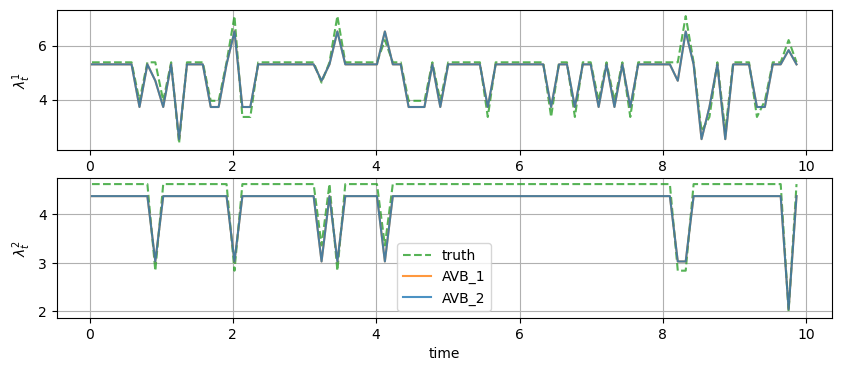

In [8]:
# Estimated intensity using mean variational posterior estimate
Tmax = 10
points_hawkes_tmax = [points_hawkes[i][points_hawkes[i] < Tmax] for i in range(len(points_hawkes))]

# using first VI algorithm
vi_intensity_1, timestamps  = intensity_process(vi_model_1, points_hawkes_tmax)

# using second VI algorithm
vi_intensity_2, timestamps  = intensity_process(vi_model_2, points_hawkes_tmax)

# True intensity
true_intensity, timestamps = intensity_process(hawkes_model, points_hawkes_tmax)


fig, ax = plt.subplots(number_of_dimensions, 1, figsize=(10, 4))
for i in range(number_of_dimensions):
    if number_of_dimensions > 1:
        a = ax[i]
    else:
        a = ax
    a.plot(timestamps, true_intensity[i], label=f'truth', alpha=0.8, color='tab:green', linestyle='dashed')
    a.plot(timestamps,  vi_intensity_1[i], label=f'AVB_1', alpha=0.8, color='tab:orange')
    a.plot(timestamps, vi_intensity_2[i], label=f'AVB_2', alpha=0.8, color='tab:blue')
    a.set_xlabel('time')
    a.set_ylabel(rf'$\lambda^{i+1}_t$')
    a.grid()
a.legend()

/var/folders/ln/mt7_y5mj77b80jtb6mmpk3_r0000gp/T/ipykernel_31530/4169128491.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  a.grid(b=True)
/var/folders/ln/mt7_y5mj77b80jtb6mmpk3_r0000gp/T/ipykernel_31530/4169128491.py:54: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  a.grid(b=True)


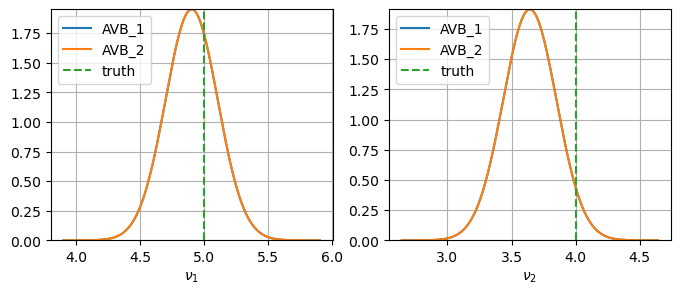

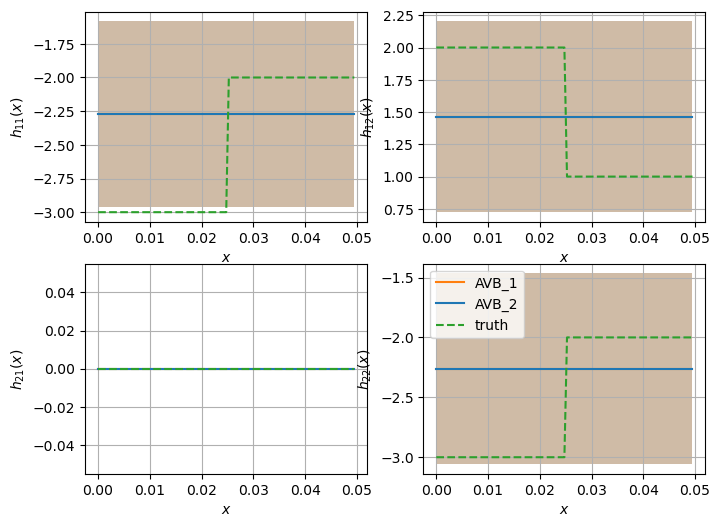

In [9]:
# Estimated parameter

# background rates
fig, ax = plt.subplots(1, number_of_dimensions, figsize=(4* number_of_dimensions,3))
for i in range(number_of_dimensions):
    if number_of_dimensions == 1:
        a = ax
    else:
        a = ax[i]
    x = np.linspace(mean_nu_1[i]-1, mean_nu_1[i]+1, 1000)
    q1_nu = norm.pdf(x, loc=mean_nu_1[i], scale=np.sqrt(cov_1[i][0,0]))
    a.plot(x, q1_nu, label='AVB_1')
    q2_nu = norm.pdf(x, loc=mean_nu_2[i], scale=np.sqrt(cov_2[i][0,0]))
    a.plot(x, q2_nu, label='AVB_2')
    a.set_ylim(0,max(max(q1_nu), max(q2_nu)))
    a.vlines(x=base_activation[i], ymin=0, ymax=max(max(q1_nu), max(q2_nu)), linestyles='dashed', label='truth', color='tab:green')
    a.legend(loc='upper left')
    a.grid(b=True)
    a.set_xlabel(rf'$\nu_{i+1}$')

# interaction functions
if basis == 'fourier':
    fb = Fourier(domain_range=[0, A], n_basis=number_of_basis,period=A)
elif basis == 'histogram':
    bins_true = np.linspace(0, A, num=number_of_basis+1)
else:
    raise ValueError
x = np.linspace(0, A, num=100)[:-1]
y_true = np.digitize(x, bins=bins_true) - 1

bins_m1 = np.linspace(0, A, num=model_1[1]+1)
y1 = np.digitize(x, bins=bins_m1) - 1
bins_m2 = np.linspace(0, A, num=model_2[1]+1)
y2 = np.digitize(x, bins=bins_m2) - 1

fig, ax = plt.subplots(number_of_dimensions,number_of_dimensions , figsize=(4*number_of_dimensions,3*number_of_dimensions))
for i in range(number_of_dimensions):
    for j in range(number_of_dimensions):
        if number_of_dimensions == 1:
            a = ax
        else:
            a = ax[i,j]

        std_w1 = np.sqrt(np.diag(cov_1[i]))[1+j*model_1[1]:1+(j+1)*model_1[1]]
        a.plot(x, mean_weight_1[i,j][y1], label='AVB_1', color='tab:orange')
        a.fill_between(x, (mean_weight_1[i,j] - 1.96*std_w1)[y1], (mean_weight_1[i,j] + 1.96*std_w1)[y1], alpha=0.3)

        std_w2 = np.sqrt(np.diag(cov_2[i]))[1+j*model_2[1]:1+(j+1)*model_2[1]]
        a.plot(x, mean_weight_2[i,j][y2], label='AVB_2', color='tab:blue')
        a.fill_between(x, (mean_weight_2[i,j] - 1.96*std_w2)[y2], (mean_weight_2[i,j] + 1.96*std_w2)[y2], alpha=0.3)

        a.plot(x, sparse_weight[i][j][y_true], label='truth',  color='tab:green', linestyle='dashed')
        a.set_xlabel(r'$x$')
        a.grid(b=True)
        id_latex=(i+1)*10+(j+1)
        a.set_ylabel(r'$h_{{{}}}(x)$'.format(id_latex))
a.legend()


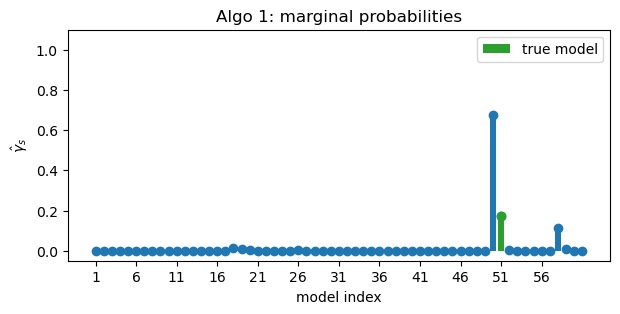

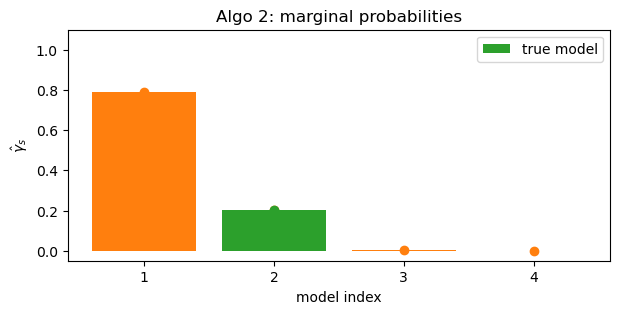

In [25]:
# 'Models' marginal probabilities
for i,m in enumerate(vi_model_1.set_of_models):
    if (m[0] == graph).all() and m[1] == number_of_basis:
        true_model1 = i

for i,m in enumerate(vi_model_2.set_of_models):
    if (m[0] == graph).all() and m[1] == number_of_basis:
        true_model2 = i

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.set_title("Algo 1: marginal probabilities")
ax.bar(x=range(1,len(vi_model_1.vpost_proba)+1), height=vi_model_1.vpost_proba, color='tab:blue')
ax.scatter(x=range(1,len(vi_model_1.vpost_proba)+1), y=vi_model_1.vpost_proba, color='tab:blue')
ax.bar(x=true_model1+1, height=vi_model_1.vpost_proba[true_model1], color='tab:green', label="true model")
ax.scatter(x=true_model1+1, y=vi_model_1.vpost_proba[true_model1], color='tab:green')
ax.set_xlabel('model index')
ax.set_ylabel(r'$\hat \gamma_{s}$')
ax.set_ylim(-0.05, 1.1)
ax.set_xticks(np.arange(1,len(vi_model_1.vpost_proba),5))
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.set_title("Algo 2: marginal probabilities")
ax.bar(x=range(1,len(vi_model_2.vpost_proba)+1), height=vi_model_2.vpost_proba, color='tab:orange')
ax.scatter(x=range(1,len(vi_model_2.vpost_proba)+1), y=vi_model_2.vpost_proba, color='tab:orange')
ax.bar(x=true_model2+1, height=vi_model_2.vpost_proba[true_model2], color='tab:green', label="true model")
ax.scatter(x=true_model2+1, y=vi_model_2.vpost_proba[true_model2], color='tab:green')
ax.set_xlabel('model index')
ax.set_ylabel(r'$\hat \gamma_{s}$')
ax.set_ylim(-0.05, 1.1)
ax.set_xticks(np.arange(1,len(vi_model_2.vpost_proba)+1,len(vi_model_2.vpost_proba)//5+1))
ax.legend()